In [1]:
import numpy as np
import pandas as pd

from stable_baselines3 import TD3
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.noise import NormalActionNoise

from envs.bess_env import BatteryEnv
from utils.csv_handler import load_price_data
from utils.plot_handler import plot_bess_rollout
from utils.eval_handler import evaluate_financials, evaluate_rollout
from utils.forecast_scenario import ForecastScenarioGenerator

In [2]:
# === Load training data: full November 2024 ===
dfp_train, price_train, ts_train = load_price_data(
    csv_path="../../data/electricity_price/dayahead_2024_11.csv",
    resolution="15min",
)

# === Load evaluation data: first week of November 2025 ===
dfp_eval, price_eval, ts_eval = load_price_data(
    csv_path="../../data/electricity_price/dayahead_2025_11.csv",
    resolution="15min",
    time_range=("2025-11-01", "2025-11-07"),
)

print(len(price_eval), "time steps in a week (should be 672)")
print("Week from", ts_train[0], "to", ts_train[-1])

672 time steps in a week (should be 672)
Week from 2024-11-01 00:00:00+01:00 to 2024-11-30 23:45:00+01:00


In [3]:
forecast_horizon_hours=3.0 # 3h
dt_hours=0.25 # 15 min
H = int(round(forecast_horizon_hours / dt_hours))  # 3h forecast, 15 min steps → 12 steps

# --------------------------------------------------
# Price forecast uncertainty scenarios (deterministic)
# --------------------------------------------------
price_scenario_gen = ForecastScenarioGenerator(
    horizon_steps=H,
    sigma0=0.01,       # small uncertainty for near future
    sigmaH=0.06,       # larger uncertainty for further future
    schedule="sqrt",   # realistic growth
    base_seed=1234,    # IMPORTANT: same seed = same scenarios
)

# ------------------------------------------------
# Training environment: uses full November 2024 as pool,
# each episode ~ one week starting at a random index.
# ------------------------------------------------
train_env_raw = BatteryEnv(
    price_series=price_train,
    timestamps=ts_train,
    dt_hours=dt_hours,              
    capacity_kWh=50.0,
    p_max_kW=10.0,
    use_discrete_actions=False,  # continuous for TD3
    use_price_forecast=True,
    forecast_horizon_hours=forecast_horizon_hours,
    episode_days=7.0,              # one-week logical episode
    random_start=True,  
    random_seed=45,
    price_scenario_gen=price_scenario_gen,
)

# Wrap with Monitor so SB3 can track episode rewards/lengths
train_env = Monitor(train_env_raw)

# Action noise for TD3 (needed for exploration)
n_actions = train_env.action_space.shape[-1]   # should be 1
action_noise = NormalActionNoise(
    mean=np.zeros(n_actions),
    sigma=0.1 * np.ones(n_actions),            # exploration strength
)

td3_model = TD3(
    "MlpPolicy",
    train_env,
    action_noise=action_noise,
    learning_rate=1e-3,
    buffer_size=100_000,
    learning_starts=1_000,
    batch_size=256,
    tau=0.005,
    gamma=0.99,
    train_freq=(1, "step"),
    gradient_steps=1,
    policy_delay=2,
    verbose=1,
)

td3_model.learn(
    total_timesteps=40_000,
    log_interval=10,
    progress_bar=True,
)

print("TD3 training completed.")
print(train_env.observation_space.shape)

 100% ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 39,989/40,000  [ 0:11:40 < 0:00:01 , 55 it/s ]

TD3 training completed.
(21,)


Episode finished after 672 steps
=== Financial Summary ===
Total revenue    (EUR): 13.838
Degradation cost (EUR): 0.881
Penalty cost     (EUR): 0.000
Total reward     (EUR): 12.957


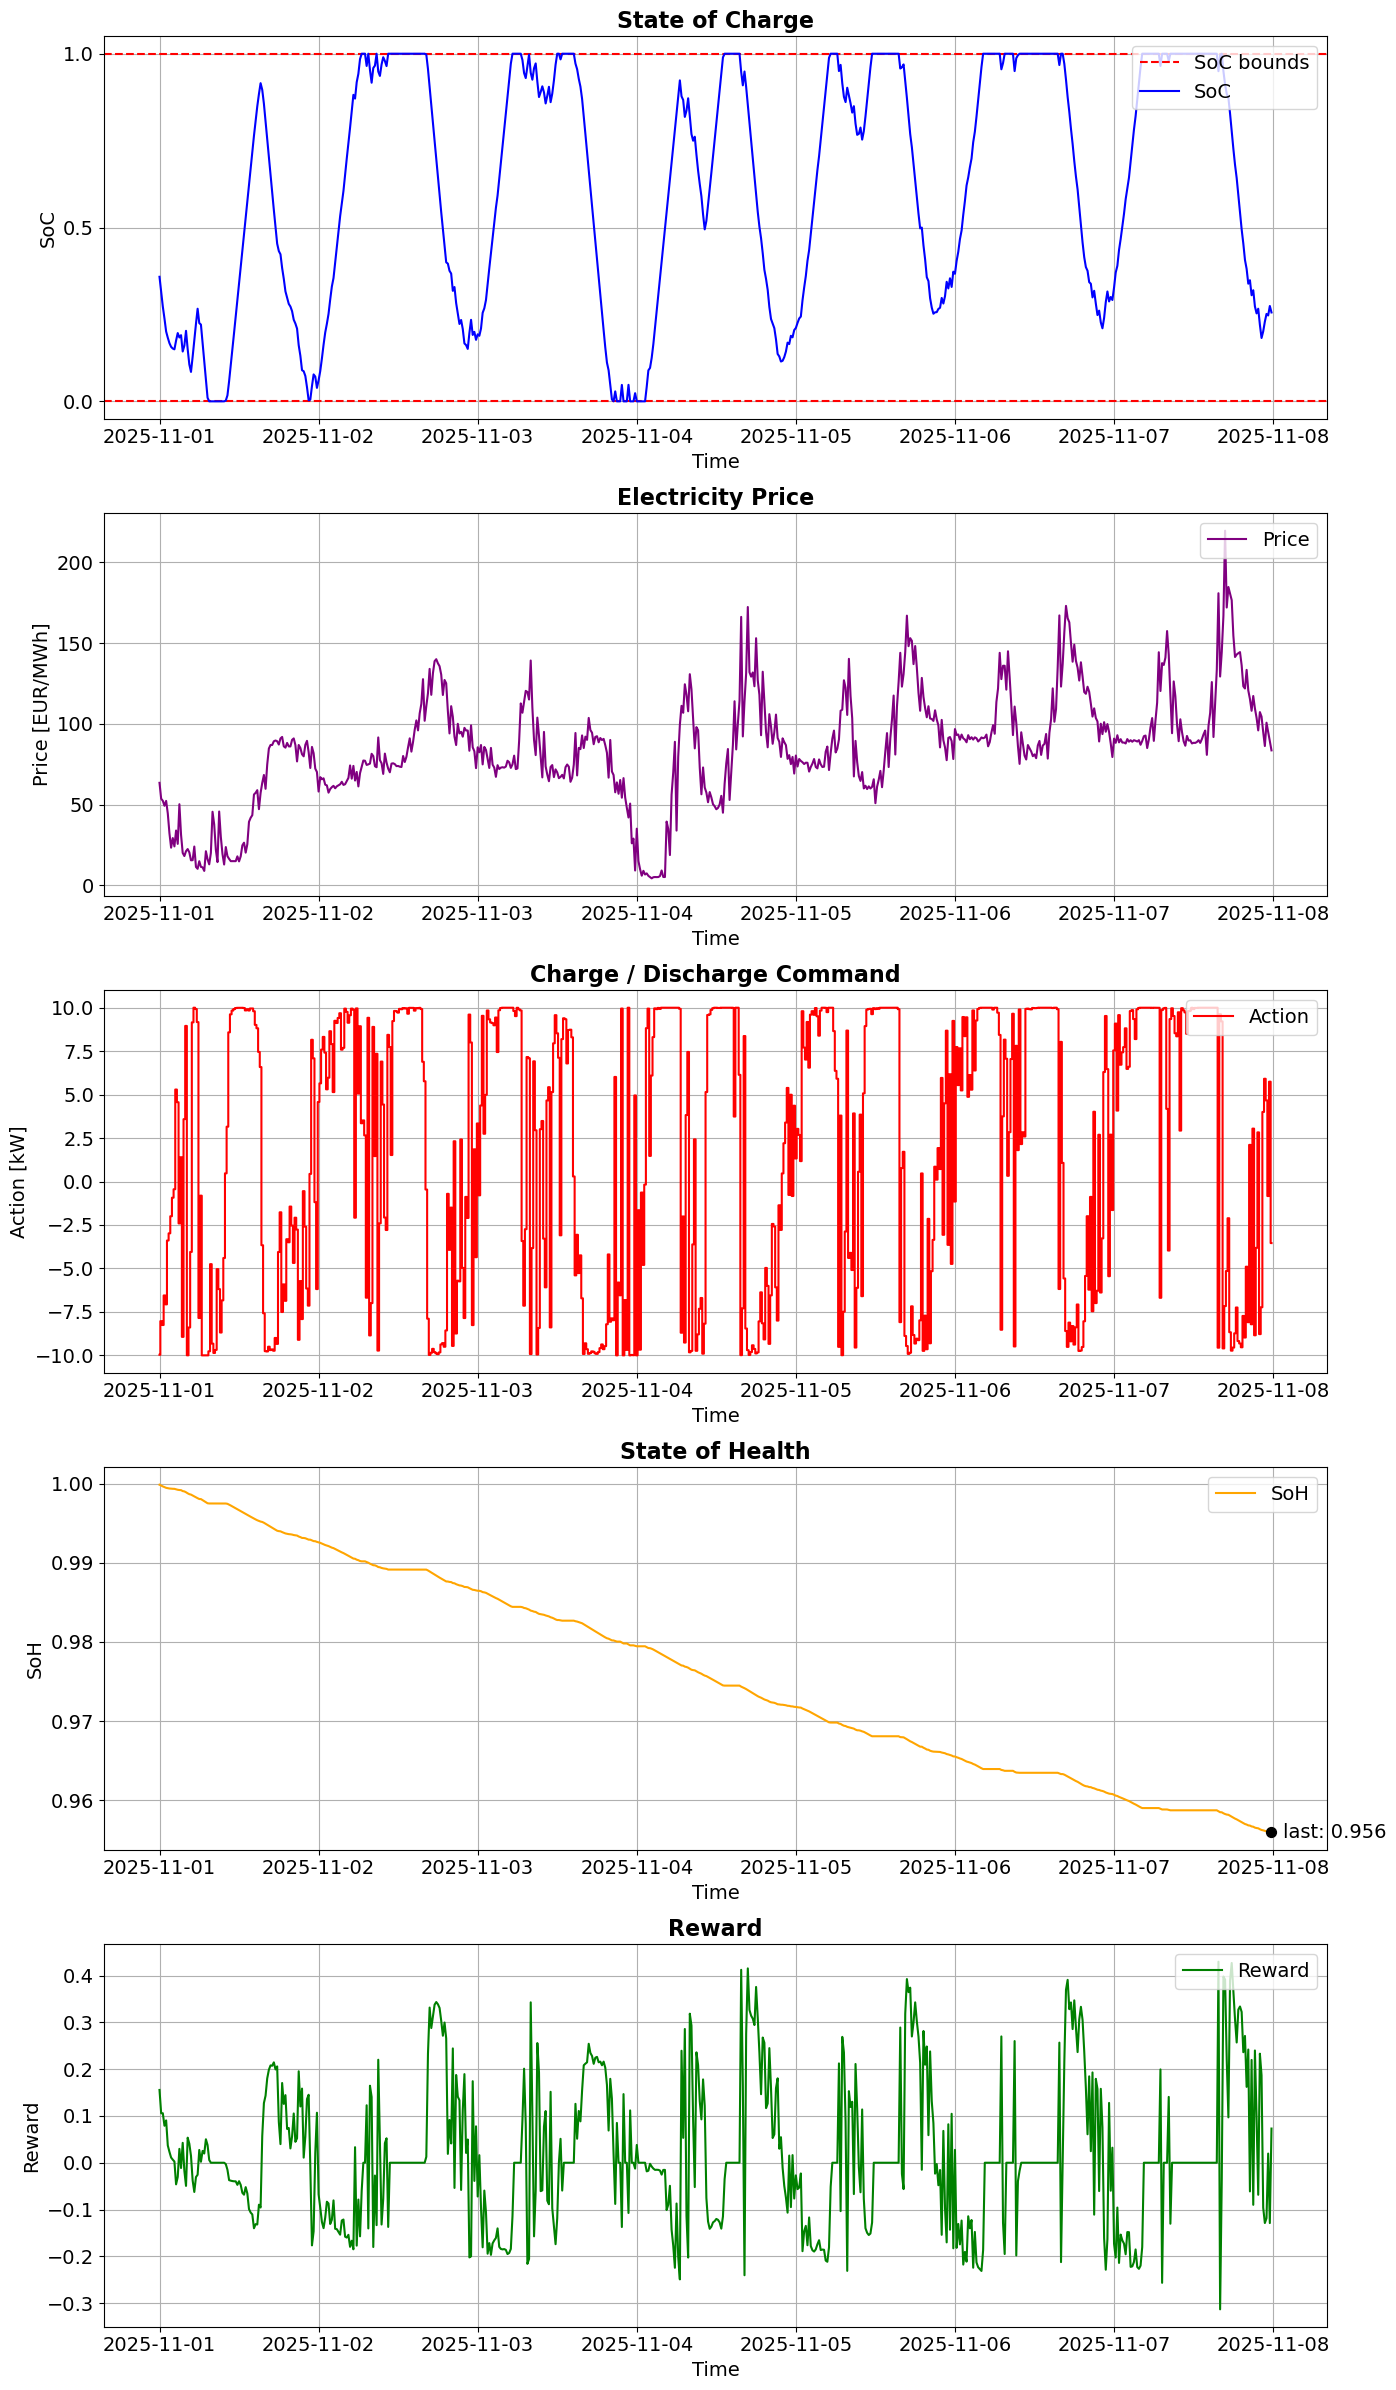

In [4]:
# Create evaluation environment on first week of November
eval_env = BatteryEnv(
    price_series=price_eval,
    timestamps=ts_eval,
    dt_hours=dt_hours,
    capacity_kWh=50.0,
    p_max_kW=10.0,
    use_discrete_actions=False,   # continuous
    use_price_forecast=True,
    forecast_horizon_hours=forecast_horizon_hours,
    episode_days=7.0,             # matches the eval week length
    random_start=False, 
    random_seed=123, 
    price_scenario_gen=price_scenario_gen,
    scenario_id=0,
    vary_scenario_per_episode=False, 
)

results = evaluate_rollout(
    model=td3_model,
    env=eval_env,
)

evaluate_financials(
    revenue_list=results["revenue"],
    deg_cost_list=results["deg_cost"],
    penalty_list=results["penalty"],
)

plot_bess_rollout(
    soc_list=results["soc"],
    soh_list=results["soh"],
    reward_list=results["reward"],
    price_list=results["price_true"],
    action_list=results["action"],
    timestamps=ts_eval,
)